In [1]:
# --- Imports & setup ---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import scipy

In [2]:
keras.backend.set_floatx('float32')
tf.random.set_seed(123)
np.random.seed(123)

## Load Heston traning data (call price / Implied volatility)



In [31]:
# --- Load dataset ---

# dataset = np.load('heston_data/Heston_ql_LHS_Feller_CALL_r_0.0_T_K_20k.npy')
# dataset = np.load('heston_data/Heston_ql_LHS_Feller_IV_r_0.0_T_K_20k.npy')

# dataset = np.load('heston_data/Heston_COS_LHS_Feller_IV_r_0.0_T_K_20k.npy')
# dataset = np.load('heston_data/Heston_COS_LHS_Feller_CALL_r_0.0_T_K_20k.npy')

dataset = np.load('heston_data/Heston_P1P2_LHS_Feller_IV_r_0.0_T_K_20k.npy')
# dataset = np.load('heston_data/Heston_P1P2_LHS_Feller_CALL_r_0.0_T_K_20k.npy')

##--- use data from NN-StochVol-Calibrations ----
# import gzip
# dataset = np.load(gzip.GzipFile('heston_data/HestonTrainSet.txt.gz', 'r'))

print("dataset shape:", dataset.shape)
print("NaNs in dataset:", np.isnan(dataset).sum())

dataset shape: (20000, 93)
NaNs in dataset: 0


## Strike  (11) and Maturity (8)

In [32]:
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

## Typical Heston Parameter Bounds

| Index | Parameter  | Description                    | Lower Bound ($\theta^i_{min}$) | Upper Bound ($\theta^i_{max}$) |
|-------|------------|-------------------------------|---------------------|---------------------|
| 0     | $v_0$      | Initial (forward) variance    | $0.0001$            | $0.04$              |
| 1     | $\rho$     | Correlation (spot-vol)        | $-0.95$             | $-0.1$              |
| 2     | $\sigma$   | Volatility of volatility      | $0.01$              | $1.0$               |
| 3     | $\theta$   | Long-term variance            | $0.01$              | $0.2$               |
| 4     | $\kappa$   | Mean reversion speed          | $1$                 | $10.0$              |

**Why these bounds?**
- $\rho$: Constrained to strongly negative values, reflecting the typical leverage effect in equities.
- $\sigma$: Prevents variance-of-variance from being near-zero (degenerate process) or unrealistically high.
- $\theta$: Ensures the long-run variance stays within observed historical market ranges.
- $\kappa$: Avoids unrealistically fast or slow mean reversion.
- $v_0$: Guarantees strictly positive, reasonable starting variance.

In [33]:
# Columns: [5 params | 88 outputs]
param_names = ['v0', 'rho', 'sigma', 'theta', 'kappa']

X_all = dataset[:, :5]   # inputs (features): parameters
y_all = dataset[:, 5:]   # targets (labels): 88-dim outputs

print("X_all shape (N,5):", X_all.shape)
print("y_all shape (N,88):", y_all.shape)
# assert y_all.shape[1] == 88, "Expected 88 outputs per row."

# Replace all negative values with NaN
y_all[y_all < 0] = np.nan

print("y min/max:", np.min(y_all), np.max(y_all))
print("Negative y:", np.sum(y_all <= 0))
print("NaN y:", np.isnan(y_all).sum())

for i, name in enumerate(param_names):
    col = X_all[:, i]
    print(f"{name}: min = {col.min()}, max = {col.max()}")

X_all shape (N,5): (20000, 5)
y_all shape (N,88): (20000, 88)
y min/max: 0.07930011 0.6166694
Negative y: 0
NaN y: 0
v0: min = 0.0001015371672110632, max = 0.03998972848057747
rho: min = -0.9404667019844055, max = -0.10057505965232849
sigma: min = 0.37403491139411926, max = 0.9999666810035706
theta: min = 0.016048315912485123, max = 0.1999969631433487
kappa: min = 1.0285751819610596, max = 9.999093055725098


## Plot the call / Iv Surface of traning data

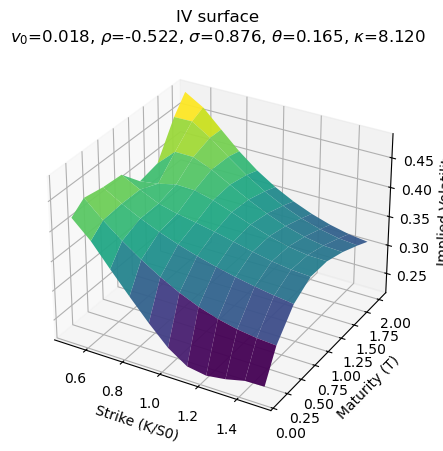

In [34]:
def plot_surface(row_idx):
    """Plot call price surface for a given row index with parameters in title."""
    surf = y_all[row_idx].reshape(len(maturities), len(strikes))
    Kgrid, Tgrid = np.meshgrid(strikes, maturities)

    # Extract parameters for this row
    params = X_all[row_idx]  # shape: [v0, rho, sigma, theta, kappa] (adjust if different)
    titles = [r"$v_0$", r"$\rho$", r"$\sigma$", r"$\theta$", r"$\kappa$"]
    param_str = ", ".join(f"{t}={val:.3f}" for t, val in zip(titles, params))

    # --- Plot ---
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(Kgrid, Tgrid, surf, cmap='viridis', alpha=0.95)

    # ax.set_title(f"Call price surface\n{param_str}")
    ax.set_title(f"IV surface\n{param_str}")
    ax.set_xlabel("Strike (K/S0)")
    ax.set_ylabel("Maturity (T)")
    # ax.set_zlabel("Call price")
    ax.set_zlabel("Implied Volatility")

    plt.savefig(
        f"surface_row{row_idx}.png", dpi=200, bbox_inches="tight",
        pad_inches=0.6, transparent=False,
        facecolor="white", edgecolor="none",
        orientation="landscape", format="png"
    )

    plt.show()

##----  plot one of the surface ---
plot_surface(123)


### Train and test split (80 / 20)


In [35]:
# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size=0.2, 
                                                    random_state=123)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)


Train shapes: (16000, 5) (16000, 88)
Test  shapes: (4000, 5) (4000, 88)


---

## Data Scaling

When training neural networks on Heston model data, both the $\textbf{input}$ (parameters) and $\textbf{outputs}$ (option prices or implied volatilities) are scaled for numerical stability and faster convergence.

---

### Input Scaling (Model Parameters)

Each parameter $ \theta^i $ (e.g., $ v_0, \rho, \sigma, \kappa, \theta $) is linearly scaled to the range $[-1,1]$:
$$
\text{scale}(\theta^i) = \frac{2\theta^i - \left(\theta^i_{\max} + \theta^i_{\min}\right)}{\theta^i_{\max} - \theta^i_{\min}}
$$

The inverse transformation recovers the original parameter value:
$$
\theta^i = \text{scale}(\theta^i) \cdot \frac{\theta^i_{\max} - \theta^i_{\min}}{2} + \frac{\theta^i_{\max} + \theta^i_{\min}}{2}
$$

- $ \theta^i $: actual (unscaled) parameter  
- $ \theta^i_{\min}, \theta^i_{\max} $: lower and upper bounds of parameter $i$

---

### Output Scaling (Prices or Implied Volatilities)


Outputs are standardized feature-wise across all samples:
$$
z = \frac{x - \mu}{\sigma}
$$

- For implied volatilities:
$$
\text{scale}(\sigma_{BS}^{i,j}) = \frac{\sigma_{BS}^{i,j} - \mathbb{E}[\sigma_{BS}^{i,j}]}{\mathrm{std}(\sigma_{BS}^{i,j})},
\quad i \in \text{Maturities},\ j \in \text{Strikes}
$$

- For call option prices:
$$
\text{scale}(C^{i,j}) = \frac{C^{i,j} - \mathbb{E}[C^{i,j}]}{\mathrm{std}(C^{i,j})},
\quad i \in \text{Maturities},\ j \in \text{Strikes}
$$

This corresponds to $\texttt{StandardScaler}$ in $\texttt{sklearn}$, where each output dimension is centered (zero mean) and normalized (unit variance).

---


In [36]:
# --- INPUT scaling: X (params) -> [-1, 1] ---
X_lb = X_all.min(axis=0)
X_ub = X_all.max(axis=0)

X_mid = 0.5 * (X_ub + X_lb)
X_span = (X_ub - X_lb)
# X_span[X_span == 0.0] = 1.0  # avoid division by zero

def scale_X(x):
    """Scale parameters to [-1,1]."""
    return (x - X_mid) * (2.0 / X_span)

def inverse_X(x_scaled):
    """Inverse scaling: recover params in original units."""
    return x_scaled * (X_span / 2.0) + X_mid

X_train_scaled = scale_X(X_train)
X_test_scaled  = scale_X(X_test)

# --- OUTPUT scaling: y (prices) -> N(0,1) with StandardScaler ---
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled  = y_scaler.transform(y_test)

def inverse_y(y_scaled):
    """Inverse scaling: recover prices in original units."""
    return y_scaler.inverse_transform(y_scaled)

print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)

param_names = ['v0', 'rho', 'sigma', 'theta', 'kappa']

print([f" {p}" for p in param_names])
print([f"{p:.5f}" for p in X_lb])
print([f"{p:.5f}" for p in X_ub])


X_train_scaled shape: (16000, 5)
y_train_scaled shape: (16000, 88)
[' v0', ' rho', ' sigma', ' theta', ' kappa']
['0.00010', '-0.94047', '0.37403', '0.01605', '1.02858']
['0.03999', '-0.10058', '0.99997', '0.20000', '9.99909']


---
## Model Overview

- **Input:** A 5-dimensional vector containing the Heston parameters: [$v_0$, $\rho$, $\sigma$, $\theta$, $\kappa$]

| Layer Type      | Number of Neurons | Activation Function | Purpose                                            |
|-----------------|-------------------|--------------------|----------------------------------------------------|
| Input           | 5                 | –                  | Ingests Heston parameters                          |
| Dense (1)       | 30                | ELU                | Nonlinear feature extraction                       |
| Dense (2)       | 30                | ELU                | Further feature transformation                     |
| Dense (3)       | 30                | ELU                | Additional nonlinearity and abstraction            |
| Output Dense    | 88                | Linear             | Outputs the entire implied volatility surface grid |

- **ELU (Exponential Linear Unit):** Used in hidden layers for smooth, efficient training.
- **Linear Activation:** Used for the output layer to predict real-valued implied volatilities.
- **Output:** An 88-dimensional vector representing the implied volatility surface, flattened from an 11 (strike) × 8 (maturity) grid.

---

In [37]:
# --- Define model ---
inputs = keras.layers.Input(shape=(5,), name="params_input")  # 5 Heston params
h = keras.layers.Dense(30, activation='elu')(inputs)
h = keras.layers.Dense(30, activation='elu')(h)
h = keras.layers.Dense(30, activation='elu')(h)
outputs = keras.layers.Dense(88, activation='linear', name="prices_output")(h)  # 88 prices/IVs

modelGEN = keras.models.Model(inputs=inputs, outputs=outputs)
modelGEN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 params_input (InputLayer)   [(None, 5)]               0         
                                                                 
 dense_3 (Dense)             (None, 30)                180       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 30)                930       
                                                                 
 prices_output (Dense)       (None, 88)                2728      
                                                                 
Total params: 4,768
Trainable params: 4,768
Non-trainable params: 0
_________________________________________________________________


In [38]:
# --- Custom RMSE loss ---
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

modelGEN.compile(optimizer="adam", loss=root_mean_squared_error)

# --- Train ---
history = modelGEN.fit(
    X_train_scaled,    # inputs: scaled params
    y_train_scaled,    # outputs: scaled prices
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=200,
    shuffle=True,
    verbose=True
)

Epoch 1/200
500/500 [==============================] - 0s 568us/step - loss: 0.3283 - val_loss: 0.2088
Epoch 2/200
500/500 [==============================] - 0s 477us/step - loss: 0.1965 - val_loss: 0.1862
Epoch 3/200
500/500 [==============================] - 0s 474us/step - loss: 0.1805 - val_loss: 0.1746
Epoch 4/200
500/500 [==============================] - 0s 481us/step - loss: 0.1724 - val_loss: 0.1691
Epoch 5/200
500/500 [==============================] - 0s 476us/step - loss: 0.1677 - val_loss: 0.1664
Epoch 6/200
500/500 [==============================] - 0s 470us/step - loss: 0.1637 - val_loss: 0.1631
Epoch 7/200
500/500 [==============================] - 0s 470us/step - loss: 0.1604 - val_loss: 0.1586
Epoch 8/200
500/500 [==============================] - 0s 468us/step - loss: 0.1579 - val_loss: 0.1571
Epoch 9/200
500/500 [==============================] - 0s 467us/step - loss: 0.1557 - val_loss: 0.1553
Epoch 10/200
500/500 [==============================] - 0s 469us/step - l

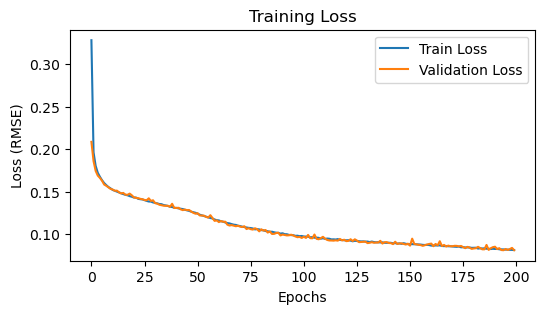

In [39]:
# --- Plot training loss ---
plt.figure(figsize=(6,3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (RMSE)")
plt.title("Training Loss")
plt.legend()
plt.show()

---

### Save model weights and the full model in Keras

---

In [12]:
# Save model weights and the full model in Keras (TensorFlow 2.x and above)
# Save only the weights (filename must end with .weights.h5)
# modelGEN.save_weights('Heston_ql_CALL_NNWeights.weights.h5')
# modelGEN.save_weights('Heston_ql_IV_NNWeights.weights.h5')

# modelGEN.save_weights('Heston_NNWeights.weights.h5')

# Save the entire model (architecture + weights + optimizer state)
# modelGEN.save('Heston_ql_CALL_full_model.h5')
# modelGEN.save('Heston_ql_IV_full_model.h5')

# modelGEN.save('Heston_COS_IV_full_model.h5')
# modelGEN.save('Heston_COS_CALL_full_model.h5')

# modelGEN.save('Heston_P1P2_CALL_full_model.h5')
modelGEN.save('Heston_P1P2_IV_full_model.h5')

# modelGEN.save('Heston_full_model.h5')

# Load only weights into a re-instantiated model
# modelGEN.load_weights('HestonNNWeights.weights.h5')

# # OR, load the complete model (including architecture and custom loss, if any)
# from keras.models import load_model
# modelGEN_loaded = load_model('Heston_full_model.h5', 
#                 custom_objects={'root_mean_squared_error': root_mean_squared_error})

---

## Plot Errors

### Root Mean Square Error (RMSE)
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2}
$$

### Mean Absolute Error (MAE)
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^n \left| \hat{y}_i - y_i \right|
$$


where  
- $n$ is the number of samples,  
- $\hat{y}_i$ is the predicted value,  
- $y_i$ is the true value.
---

Test RMSE (original units): 0.004616
Test MAE  (original units): 0.002189


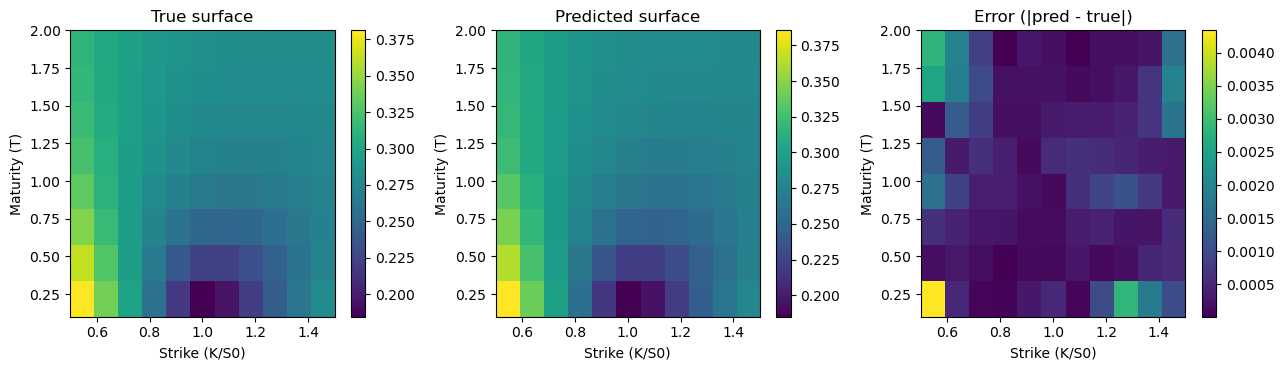

In [40]:
def evaluate_and_plot_surface(model, X_test_scaled, y_test, inverse_y, idx=0, verbose=1):

    # --- Predict and inverse transform ---
    y_pred_test_scaled = model.predict(X_test_scaled, verbose=0)
    y_pred_test = inverse_y(y_pred_test_scaled)

    y_true_test = y_test

    # --- Metrics ---
    rmse = np.sqrt(np.mean((y_pred_test - y_true_test) ** 2))
    mae  = np.mean(np.abs(y_pred_test - y_true_test))

    if verbose:
        print(f"Test RMSE (original units): {rmse:.6f}")
        print(f"Test MAE  (original units): {mae:.6f}")

    # --- Helper for reshaping ---
    def flat_to_grid(vec88):
        return vec88.reshape(len(maturities), len(strikes))

    # --- Pick sample ---
    true_grid = flat_to_grid(y_true_test[idx])
    pred_grid = flat_to_grid(y_pred_test[idx])
    err_grid  = pred_grid - true_grid

    # --- Plot ---
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.8))

    im0 = axes[0].imshow(true_grid, aspect='auto', origin='lower',
                         extent=[strikes.min(), strikes.max(), maturities.min(), maturities.max()])
    axes[0].set_title("True surface")
    axes[0].set_xlabel("Strike (K/S0)")
    axes[0].set_ylabel("Maturity (T)")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(pred_grid, aspect='auto', origin='lower',
                         extent=[strikes.min(), strikes.max(), maturities.min(), maturities.max()])
    axes[1].set_title("Predicted surface")
    axes[1].set_xlabel("Strike (K/S0)")
    axes[1].set_ylabel("Maturity (T)")
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(abs(err_grid), aspect='auto', origin='lower',
                         extent=[strikes.min(), strikes.max(), maturities.min(), maturities.max()])
    axes[2].set_title("Error (|pred - true|)")
    axes[2].set_xlabel("Strike (K/S0)")
    axes[2].set_ylabel("Maturity (T)")
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

    return rmse, mae

rmse, mae = evaluate_and_plot_surface(modelGEN, X_test_scaled, y_test, inverse_y, idx=3)


---
- **Average Relative Error**
$$
\frac{1}{n} \sum_{i=1}^n \frac{|y_i - \hat{y}_i|}{|y_i|}
$$
- - Use this for measuring overall average error, useful for normalized assessment and comparison across datasets

- **Standard Deviation of Relative Error**
$$
\sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \frac{|y_i - \hat{y}_i|}{|y_i|} - \text{Average Relative Error} \right)^2 }
$$
- - Use this to judge how consistent or spread out the relative errors are in the sample; valuable for model stability analysis
- **Maximum Relative Error**
$$
\max_{i} \frac{|y_i - \hat{y}_i|}{|y_i|}
$$
- - Use this to highlight the single largest (worst-case) prediction error as a fraction of true value, important in safety or critical applications.
---


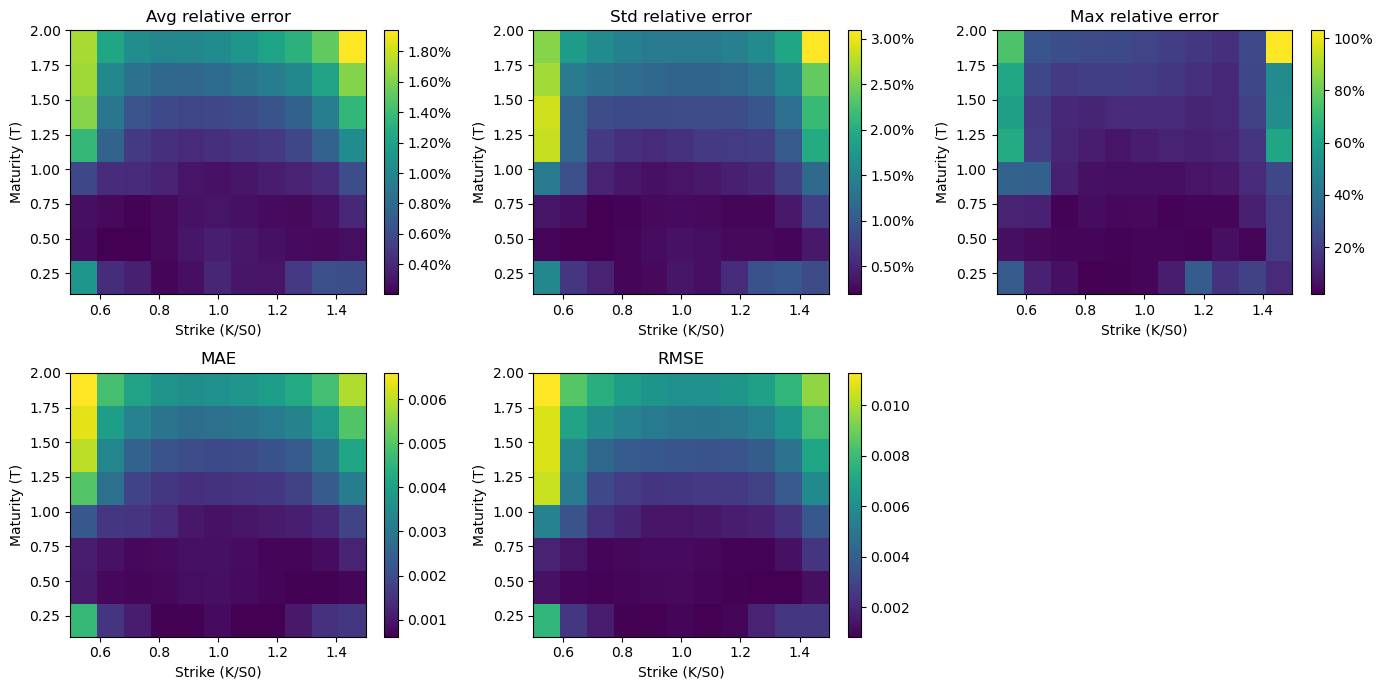

In [41]:
def plot_error_maps(model, X_test_scaled, inverse_y, y_test, strikes, maturities, thr=1e-4):
    # --- Predict & inverse transform ---
    y_pred_scaled = model.predict(X_test_scaled, verbose=0)
    y_pred = inverse_y(y_pred_scaled)
    y_true = np.asarray(y_test)

    M, K = len(maturities), len(strikes)

    # --- Absolute error ---
    abs_err = np.abs(y_pred - y_true)
    mae_grid  = np.mean(abs_err, axis=0).reshape(M, K)
    rmse_grid = np.sqrt(np.mean((y_pred - y_true)**2, axis=0)).reshape(M, K)

    rel_err = np.abs((y_pred - y_true) / np.abs(y_true))
    # --- Relative error (masked below thr) ---
    # rel_err = np.abs((y_pred - y_true) / np.maximum(np.abs(y_true),thr))
    # rel_err[y_true < thr] = np.nan

    mean_rel = np.nanmean(rel_err, axis=0).reshape(M, K)
    std_rel  = np.nanstd(rel_err,  axis=0).reshape(M, K)
    max_rel  = np.nanmax(rel_err,  axis=0).reshape(M, K)

    # --- Plot ---
    fig, axes = plt.subplots(2, 3, figsize=(14, 7))

    def draw(ax, grid, title, percent=False):
        im = ax.imshow(grid, origin='lower', aspect='auto',
                       extent=[strikes.min(), strikes.max(), maturities.min(), maturities.max()],
                       cmap='viridis')
        ax.set_title(title)
        ax.set_xlabel("Strike (K/S0)")
        ax.set_ylabel("Maturity (T)")
        if percent:
            plt.colorbar(im, ax=ax, format=mtick.PercentFormatter(xmax=1.0))
        else:
            plt.colorbar(im, ax=ax)
        return im

    draw(axes[0,0], mean_rel, "Avg relative error", percent=True)
    draw(axes[0,1], std_rel,  "Std relative error", percent=True)
    draw(axes[0,2], max_rel,  "Max relative error", percent=True)

    draw(axes[1,0], mae_grid,  "MAE")
    draw(axes[1,1], rmse_grid, "RMSE")
    # draw(axes[1,2], abs_err, "abs err")
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()

## -------

plot_error_maps(modelGEN, X_test_scaled, inverse_y, y_test, strikes, maturities)


True params: [ 0.01943595 -0.1964732   0.8400053   0.1784173   2.0699122 ]


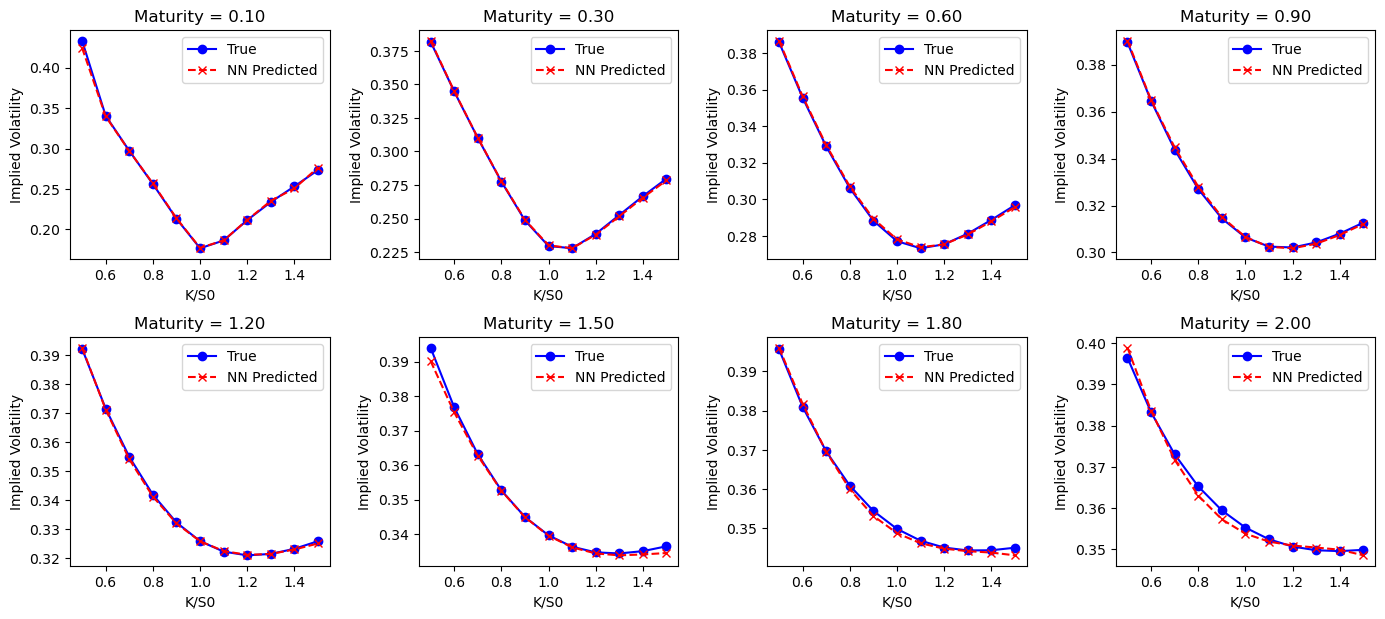

In [51]:
# --- Pick a test sample ---
sample_idx = 124

# Grid dims
S0 = 1.0
strikes_dim = len(strikes)
maturities_dim = len(maturities)

# True inputs/outputs (original units)
params_true  = X_test[sample_idx]       # shape (5,)
surface_true = y_test[sample_idx]       # shape (88,)

print("True params:", params_true)

# --- Predict with the trained model ---
params_scaled   = scale_X(params_true.reshape(1, -1))     # [-1, 1]
pred_scaled     = modelGEN.predict(params_scaled, verbose=0)
surface_pred    = inverse_y(pred_scaled)[0]               # back to original units

# --- Plot strike slices for each maturity ---
plt.figure(figsize=(14, 12))
for i, T in enumerate(maturities):
    ax = plt.subplot(4, 4, i + 1)
    i0, i1 = i * strikes_dim, (i + 1) * strikes_dim
    ax.plot(strikes / S0, surface_true[i0:i1], 'b-', label="True", marker='o')
    ax.plot(strikes / S0, surface_pred[i0:i1], '--r', label="NN Predicted", marker='x')
    ax.set_title(f"Maturity = {T:.2f}")
    ax.set_xlabel("K/S0")
    # ax.set_ylabel("Call Price")
    ax.set_ylabel("Implied Volatility")
    ax.legend()

plt.tight_layout()
plt.savefig("HestonNN_Surface.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()


In [54]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

print(len(modelGEN.layers))

# Print the shapes of weights and biases for each neural network layer
for i, layer_params in enumerate(NNParameters, start=1):
    # print(i)
    weight_shape = layer_params[0].shape  # weights (matrix)
    bias_shape = layer_params[1].shape    # bias (vector)
    print(f"Layer {i}: Weights shape = {weight_shape}, Bias shape = {bias_shape}")

5
Layer 1: Weights shape = (5, 30), Bias shape = (30,)
Layer 2: Weights shape = (30, 30), Bias shape = (30,)
Layer 3: Weights shape = (30, 30), Bias shape = (30,)
Layer 4: Weights shape = (30, 88), Bias shape = (88,)


## Neural Network with ELU Activation and Cost Functions

- `NumLayers = 3` hidden layers.  
- `NNParameters`: list of $(W, b)$ pairs where  
  - $W \in \mathbb{R}^{n_{\text{in}} \times n_{\text{out}}}$,  
  - $b \in \mathbb{R}^{n_{\text{out}}}$.

### ELU Activation
$$
\text{ELU}(x) =
\begin{cases}
x & x \ge 0 \\
e^x - 1 & x < 0
\end{cases},
\quad
\text{ELU}'(x) =
\begin{cases}
1 & x \ge 0 \\
e^x & x < 0
\end{cases}
$$


### Forward Pass
- Input: `x_scaled ∈ [-1,1]^5`.  
- Each hidden layer:  
  $z = xW + b$, then apply ELU.  
- Output layer: linear only → vector in $\mathbb{R}^{88}$ (scaled $y$-space).

### Cost Functions
- **Scalar loss**:  
  $$
  J(x) = \|\hat{y}(x) - y_{\text{true}}\|^2
  $$
  (for custom training).  

- **Residuals**:  
  $$
  r(x) = \hat{y}(x) - y_{\text{true}}
  $$
  (for SciPy `least_squares`, which squares & sums internally).

In [55]:
NumLayers = 3  # you have 3 hidden layer

# --- ELU and its derivative (no in-place edits) ---
def elu(x):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    pos = x >= 0
    out[pos]  = x[pos]
    out[~pos] = np.exp(x[~pos]) - 1.0
    return out

def eluPrime(x):
    # derivative wrt the pre-activation x
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    pos = x >= 0
    out[pos]  = 1.0
    out[~pos] = np.exp(x[~pos])
    return out

# --- Forward pass using SCALED params in [-1,1]; output in SCALED y-space ---
def NeuralNetwork(x_scaled):
    """
    x_scaled: (5,) parameters already scaled with your scale_X ([-1,1])
    returns:  (88,) prediction in y-scaled space (i.e., same space as y_train_scaled)
    """
    input1 = np.asarray(x_scaled, dtype=float).ravel()

    # hidden layers (linear -> ELU)
    for i in range(NumLayers):
        W, b = NNParameters[i]            # W: (n_in, n_out), b: (n_out,)
        input1 = np.dot(input1, W) + b    # linear transform
        # input1 = input1 @ W + b           # linear transform
        input1 = elu(input1)              # ELU activation

    # final output layer (linear only)
    W_out, b_out = NNParameters[i + 1]
    return np.dot(input1, W_out) + b_out  # (88,)
    # return input1 @ W_out + b_out         # (88,)

# --- Cost: compare in SCALED y-space (your y_test_scaled) ---
def CostFunc(x_scaled, sample_ind):
    """
    x_scaled: (5,) candidate in [-1,1]
    sample_ind: index into test set (targets in y_test_scaled)
    """
    pred = NeuralNetwork(x_scaled)                 # (88,)
    target = y_test_scaled[sample_ind]             # (88,)
    r = pred - target
    return np.dot(r, r)                            # sum of squares

# --- Levenberg–Marquardt style residuals/Jacobian (SciPy least_squares) ---
def CostFuncLS(x_scaled, sample_ind):
    """
    Residual vector in scaled y-space, length 88.
    """
    return NeuralNetwork(x_scaled) - y_test_scaled[sample_ind]


## Calibration of test data using various optimization techniques

In [56]:

all_solutions = []   # list of (3, 5) arrays per sample: rows = [L-BFGS-B, SLSQP, BFGS]
all_timings   = []   # list of (3,) arrays per sample: elapsed seconds per method

methods = ["L-BFGS-B", "SLSQP", "BFGS", "Levenberg–Marquardt"]

solutions = np.zeros((len(methods), 5))   # [method_id, params]
timings   = np.zeros(len(methods))        # timing for each method

# Neutral initial guess (in scaled param space: [-1,1])
init_guess_scaled = np.zeros(5)

# how many test points to evaluate
N_eval = min(1000, X_test.shape[0])

for sample_ind in range(N_eval):
    # print(f"{sample_ind+1}/{N_eval}", end="\r", "-" * 40)
    print(f"{sample_ind+1}/{N_eval} {'-' * 60}", end="\r")

    # Ground truth parameters (already in ORIGINAL units, since y_test is unscaled here)
    true_params = X_test[sample_ind]

    # ---------- L-BFGS-B ----------
    start = time.time()
    result = scipy.optimize.minimize(
        CostFunc,
        x0=init_guess_scaled,
        args=(sample_ind,),
        method="L-BFGS-B"
        # ,jac=Jacobian, tol=1e-10, options={"maxiter": 5000}
    )
    end = time.time()
    solutions[0, :] =  inverse_X(result.x)   # map back to original param units
    timings[0] = end - start

    # print("\nMethod: L-BFGS-B  | success:", result.success, " | time(s):", f"{timings[0]:.4f}")
    # print("orig:", [f"{p:.5f}" for p in true_params])
    # print("est :", [f"{p:.5f}" for p in solutions[0, :]])

    # ---------- SLSQP ----------
    start = time.time()
    result = scipy.optimize.minimize(
        CostFunc,
        x0=init_guess_scaled,
        args=(sample_ind,),
        method="SLSQP"
    )
    end = time.time()
    solutions[1, :] =  inverse_X(result.x)
    timings[1] = end - start

    # print("\nMethod: SLSQP  | success:", result.success, " | time(s):", f"{timings[1]:.4f}")
    # print("orig:", [f"{p:.5f}" for p in true_params])
    # print("est :", [f"{p:.5f}" for p in solutions[1, :]])

    # ---------- BFGS ----------
    start = time.time()
    result = scipy.optimize.minimize(
        CostFunc,
        x0=init_guess_scaled,
        args=(sample_ind,),
        method="BFGS"
    )
    end = time.time()
    solutions[2, :] =  inverse_X(result.x)
    timings[2] = end - start

    # print("\nMethod: BFGS  | success:", result.success, " | time(s):", f"{timings[2]:.4f}")
    # print("orig:", [f"{p:.5f}" for p in true_params])
    # print("est :", [f"{p:.5f}" for p in solutions[2, :]])

    # ---------- Levenberg–Marquardt ----------
    start = time.time()
    result = scipy.optimize.least_squares(
        CostFuncLS,
        init_guess_scaled,
        # JacobianLS,
        args=(sample_ind,),
        gtol=1e-10
    )
    end = time.time()
    solutions[3, :] = inverse_X(result.x)
    timings[3] = end - start

    # print("\nMethod: Levenberg–Marquardt  | success:", result.success, " | time(s):", f"{timings[3]:.4f}")
    # print("orig:", [f"{p:.5f}" for p in true_params])
    # print("est :", [f"{p:.5f}" for p in solutions[3, :]])

    # Save results for this sample
    all_solutions.append(np.copy(solutions))
    all_timings.append(np.copy(timings))


---

## Timing the calibration for many test data

---

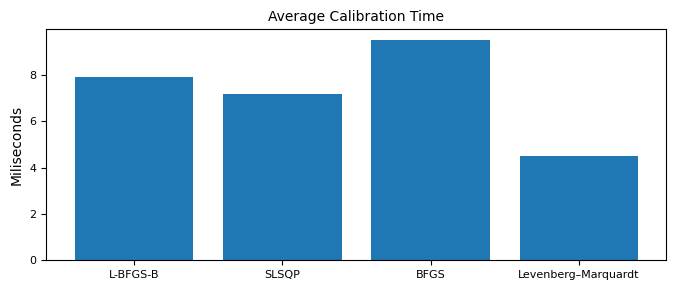

In [66]:
# methods=["L-BFGS-B ","SLSQP","BFGS"]
plt.figure(1,figsize=(8,3))
plt.bar(methods, np.mean(all_timings,axis=0)*1000 )
plt.title("Average Calibration Time",fontsize=10)
plt.ylabel("Miliseconds",fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('calib_timing.png', dpi=300)
plt.show()

---

## Relative Error Calculation for heston parameters

For each parameter and test sample:
$$
\text{Relative Error (\%)} = 100 \times \left| \frac{\text{Estimated} - \text{True}}{\text{True}} \right|
$$

---

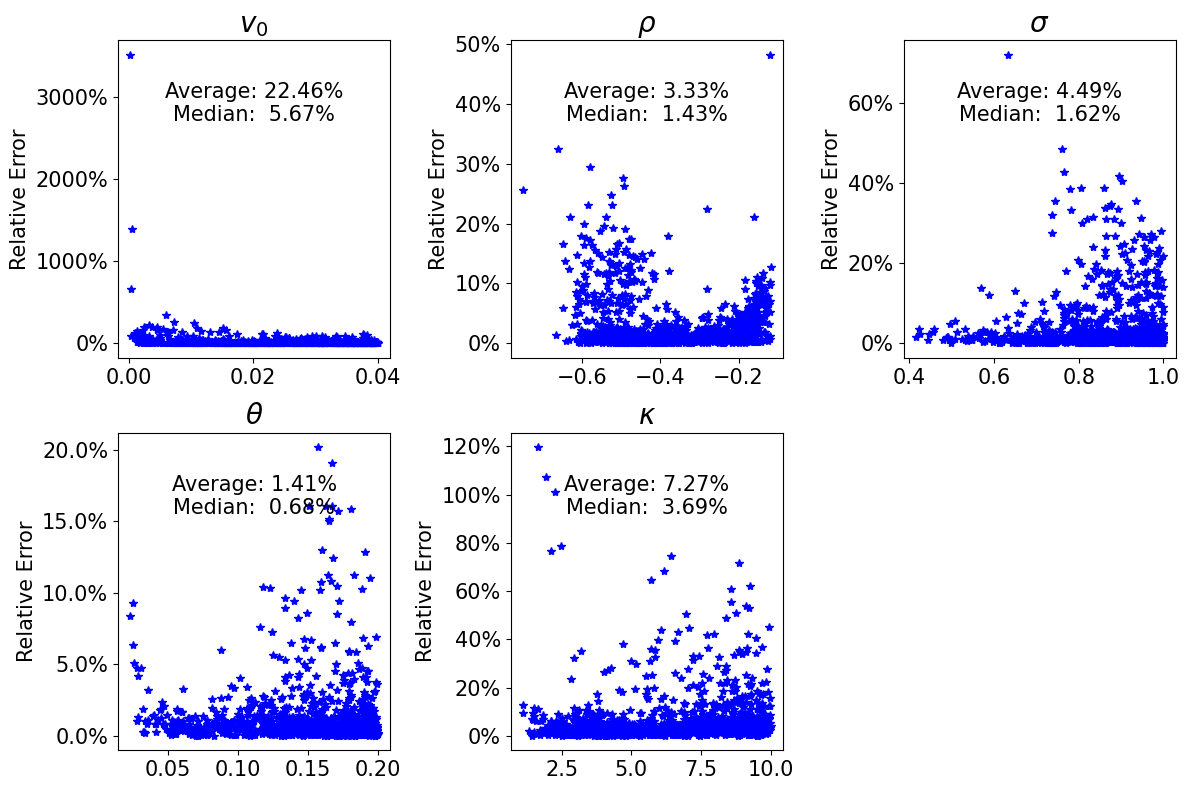

In [67]:
# stack LM solutions to (N_eval, 5)
LMParameters = np.vstack([all_solutions[i][3] for i in range(N_eval)])  # row 3 = LM

titles = ["$v_0$", "$\\rho$", "$\\sigma$", "$\\theta$", "$\\kappa$"]

average = np.zeros((5, N_eval))

fig = plt.figure(figsize=(12, 8))
for u in range(5):
    ax = plt.subplot(2, 3, u + 1)

    # true params for plotting/reference
    y_true = X_test[:N_eval, u]

    # relative error (%) for LM
    rel_err = 100.0 * np.abs(LMParameters[:N_eval, u] - y_true) / np.maximum(np.abs(y_true), 1e-12)
    average[u, :] = rel_err / 100.0  # store as fraction (not percent) like your original

    # scatter: true value vs relative error (%)
    plt.plot(y_true, rel_err, 'b*')
    plt.title(titles[u], fontsize=20)
    plt.ylabel('Relative Error', fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)

    # stats box
    avg_pct = np.mean(rel_err)
    med_pct = np.median(rel_err)
    plt.text(0.5, 0.8,
             f'Average: {avg_pct:1.2f}%\nMedian:  {med_pct:1.2f}%',
             ha='center', va='center', transform=ax.transAxes, fontsize=15)

plt.tight_layout()
# plt.savefig('HestonParameterRelativeErrors.png', dpi=300)
plt.show()

---

## Absolute Error Calculation parameters

For each parameter and test sample:

$$
\text{Absolute Error} = |\text{Estimated} - \text{True}|
$$

---

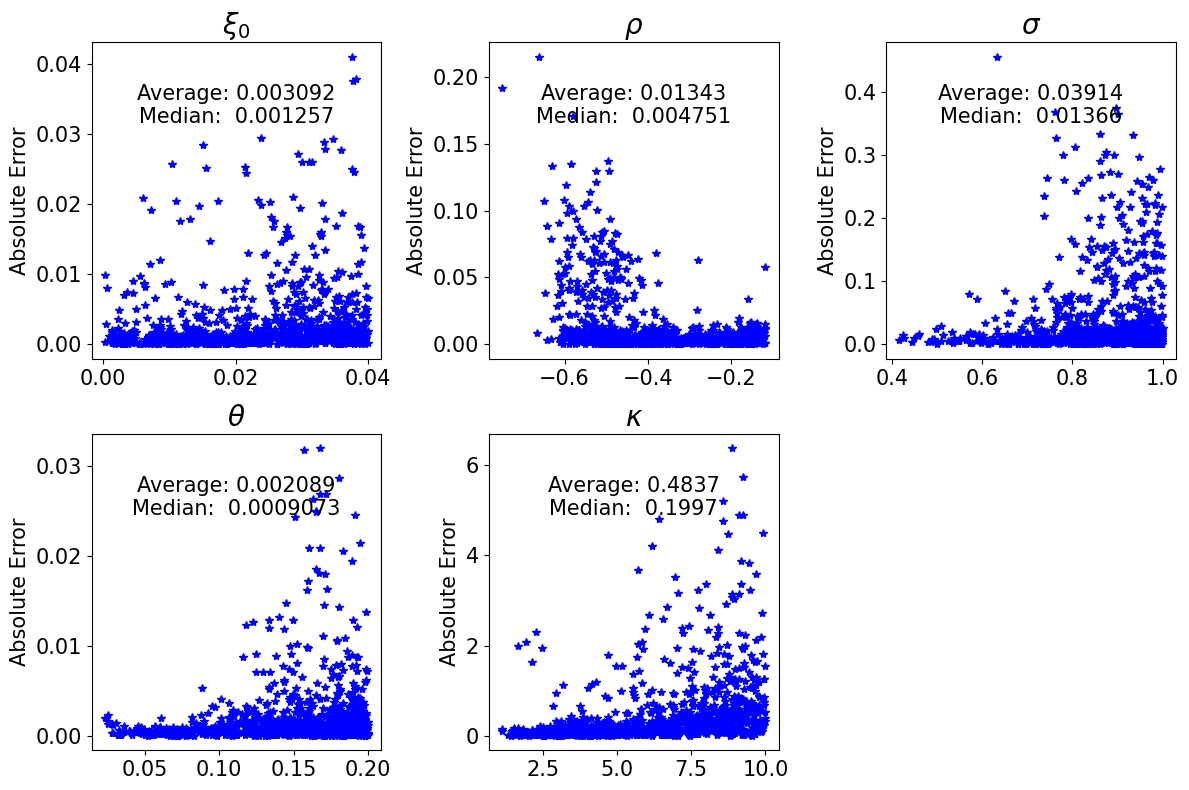

In [68]:
# stack LM solutions to (N_eval, 5)
LMParameters = np.vstack([all_solutions[i][3] for i in range(N_eval)])  # row 3 = LM

titles = [r"$\xi_0$", r"$\rho$", r"$\sigma$", r"$\theta$", r"$\kappa$"]

average = np.zeros((5, N_eval))

fig = plt.figure(figsize=(12, 8))
for u in range(5):
    ax = plt.subplot(2, 3, u + 1)

    # true params for plotting/reference
    y_true = X_test[:N_eval, u]

    # absolute error (same units as parameter)
    abs_err = np.abs(LMParameters[:N_eval, u] - y_true)
    average[u, :] = abs_err  # store absolute errors

    # scatter: true value vs absolute error
    plt.plot(y_true, abs_err, 'b*')
    plt.title(titles[u], fontsize=20)
    plt.ylabel('Absolute Error', fontsize=15)
    # no PercentFormatter for absolute error
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)

    # stats box (no % sign)
    avg_val = np.mean(abs_err)
    med_val = np.median(abs_err)
    plt.text(0.5, 0.8,
             f'Average: {avg_val:1.4g}\nMedian:  {med_val:1.4g}',
             ha='center', va='center', transform=ax.transAxes, fontsize=15)

plt.tight_layout()
# plt.savefig('HestonParameterAbsoluteErrors.png', dpi=300)
plt.show()
